In [1]:
import torchvision, torch, os, shutil, random
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
from torchsampler import ImbalancedDatasetSampler
from PIL import Image
from torchvision import transforms, datasets
from torchvision import datasets
import torchvision.models as models
from torch.utils.data import DataLoader, Dataset, random_split, WeightedRandomSampler
from torchvision.transforms import transforms
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from PIL import Image
import numpy as np
import pandas as pd

import os
import random
from operator import itemgetter
import cv2
import copy
import time

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.image import imread
import seaborn as sns

import torch
import torchvision
from torchvision.datasets import ImageFolder

from torchvision.utils import make_grid
import torchvision.transforms as transform
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from sklearn.model_selection import train_test_split
import torchvision.models as models
from torchvision.utils import make_grid
import torch.nn.functional as F

from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix, classification_report

import warnings
warnings.filterwarnings('ignore')

/home/kacper/.local/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'libc10_cuda.so: cannot open shared object file: No such file or directory'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


# Device check

First of all, I'd like to check whether or not my device is able to use a GPU for the calculations, or will I be solely reliant on my CPU. 

In [2]:
# Check if GPU is available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

# Get number of CPU cores
num_cpu_cores = os.cpu_count()
print(f"Number of CPU cores: {num_cpu_cores}")

# Get GPU name
if torch.cuda.is_available():
    gpu_name = torch.cuda.get_device_name(0)
    print(f"GPU name: {gpu_name}")
else:
    print("No GPU available")

Device: cpu
Number of CPU cores: 12
No GPU available


## Global Params 
These params will be used throughout the process, thus they need to be at the top to ensure they work with the rest of the code below.

In [3]:
params = {
    'epoch_number' : 10,
    'batch_size' : 256,
    'learning_rate' : 0.001,
    'class_amount' : 7
    }

# Exploratory Data Analysis

## Data Loading

In [4]:
# Path leading to dataset
main_path = '/home/kacper/archive/fruits-360_dataset/fruits-360/'
os.listdir(main_path)

['new_test',
 'Test',
 'readme.md',
 'new_test_transformed',
 'new_train_transformed',
 'papers',
 'Training',
 'test-multiple_fruits',
 'LICENSE',
 'new_train']

In [5]:
# Paths to folders inside 
test_dataset = main_path + 'Test/'
train_dataset = main_path + 'Training/'

In [6]:
print(f"The length of Train data is {len(os.listdir(train_dataset))} and Test data is {len(os.listdir(test_dataset))}")

The length of Train data is 131 and Test data is 131


In [7]:
os.listdir(train_dataset)

['Banana Red',
 'Tomato 2',
 'Apple Golden 1',
 'Granadilla',
 'Pepper Orange',
 'Apple Red Yellow 2',
 'Tomato 4',
 'Avocado ripe',
 'Plum 3',
 'Physalis',
 'Apple Golden 2',
 'Melon Piel de Sapo',
 'Grape White 3',
 'Apple Golden 3',
 'Lychee',
 'Peach 2',
 'Blueberry',
 'Pineapple Mini',
 'Lemon',
 'Pear Kaiser',
 'Mulberry',
 'Tomato 1',
 'Cauliflower',
 'Pepper Red',
 'Cherry Wax Red',
 'Apple Red Delicious',
 'Pepper Yellow',
 'Pepino',
 'Onion Red Peeled',
 'Papaya',
 'Cherry Wax Black',
 'Pear Forelle',
 'Grape White 4',
 'Corn Husk',
 'Nut Pecan',
 'Tomato Cherry Red',
 'Tomato Heart',
 'Cantaloupe 1',
 'Grape White',
 'Mangostan',
 'Pear Red',
 'Grapefruit White',
 'Banana Lady Finger',
 'Tomato Maroon',
 'Apple Red Yellow 1',
 'Tomato Yellow',
 'Tomato 3',
 'Kohlrabi',
 'Corn',
 'Potato Red',
 'Guava',
 'Cherry Rainier',
 'Pepper Green',
 'Tangelo',
 'Nectarine Flat',
 'Tomato not Ripened',
 'Apple Red 3',
 'Grape Blue',
 'Peach',
 'Grapefruit Pink',
 'Apple Crimson Snow',
 

In [8]:
basic_data_transforms = transforms.Compose([
    transforms.ToTensor()
])
data_transforms = transforms.Compose([
    transforms.RandomRotation(20),  
    transforms.RandomHorizontalFlip(p=0.5), 
    transforms.RandomResizedCrop(size=(100, 100), scale=(0.8, 1.0)),  
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),  
    transforms.RandomApply([transforms.RandomAffine(0, translate=(0.1, 0.1))], p=0.5),  # Randomly apply affine transformations with translation
    transforms.RandomApply([transforms.RandomPerspective(distortion_scale=0.2)], p=0.5),  # Randomly apply perspective transformations
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                            std=[0.229, 0.224, 0.225])
    ])

In [9]:
train = datasets.ImageFolder(train_dataset, transform=basic_data_transforms)
test = datasets.ImageFolder(test_dataset, transform=basic_data_transforms)
train2 = datasets.ImageFolder(train_dataset, transform=data_transforms)
test2 = datasets.ImageFolder(test_dataset, transform=data_transforms)

In [10]:
print(len(train))
print(len(test))
#print(len(train2))
#print(len(test2))

69281
22688


In [11]:
len(train) + len(test)

91969

## Data Visualisation

In [12]:
def display_random_images(dataset, num_images=5):
    dataset_size = len(dataset)

    random_indices = np.random.choice(dataset_size, num_images, replace=False)

    fig, axes = plt.subplots(1, num_images, figsize=(15, 3))

    for i, index in enumerate(random_indices):
        image_tensor = dataset[index][0]
        image_array = image_tensor.numpy()
        image_array = np.transpose(image_array, (1, 2, 0))
        axes[i].imshow(image_array)
        axes[i].axis('off')

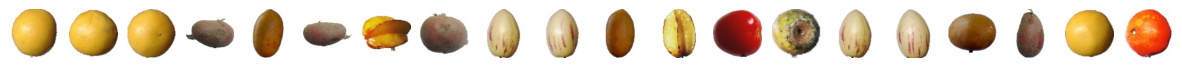

In [40]:
display_random_images(x,20)

In [14]:
image_path = '/home/kacper/archive/fruits-360_dataset/fruits-360/Training/Watermelon/r_315_100.jpg'
image = Image.open(image_path)

image_format = image.format 
image_size = image.size  
image_mode = image.mode  

print("Image format:", image_format)
print("Image size:", image_size)
print("Image mode:", image_mode)

Image format: JPEG
Image size: (100, 100)
Image mode: RGB


In [41]:
import os
import matplotlib.pyplot as plt
from matplotlib.image import imread

def display_images_in_grid(folder_path, grid_size):
    image_files = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]
    image_files = [f for f in image_files if f.lower().endswith(('.png', '.jpg', '.jpeg', '.gif'))]

    rows = int(grid_size[0])
    columns = int(grid_size[1])

    num_images = rows * columns
    if len(image_files) < num_images:
        print(f"Warning: Not enough images in the folder. Found {len(image_files)} images, expected {num_images} images.")
        num_images = min(num_images, len(image_files))

    fig = plt.figure(figsize=(10, 10))

    for i in range(num_images):
        image_path = os.path.join(folder_path, image_files[i])
        image = imread(image_path)

        ax = fig.add_subplot(rows, columns, i+1)
        ax.imshow(image)
        ax.axis('off')

    fig.tight_layout()

    plt.show()

display_images_in_grid(test_dataset + 'Pear Agate', (10, 10))

FileNotFoundError: [Errno 2] No such file or directory: '/home/kacper/archive/fruits-360_dataset/fruits-360/Test/Pear Agate'

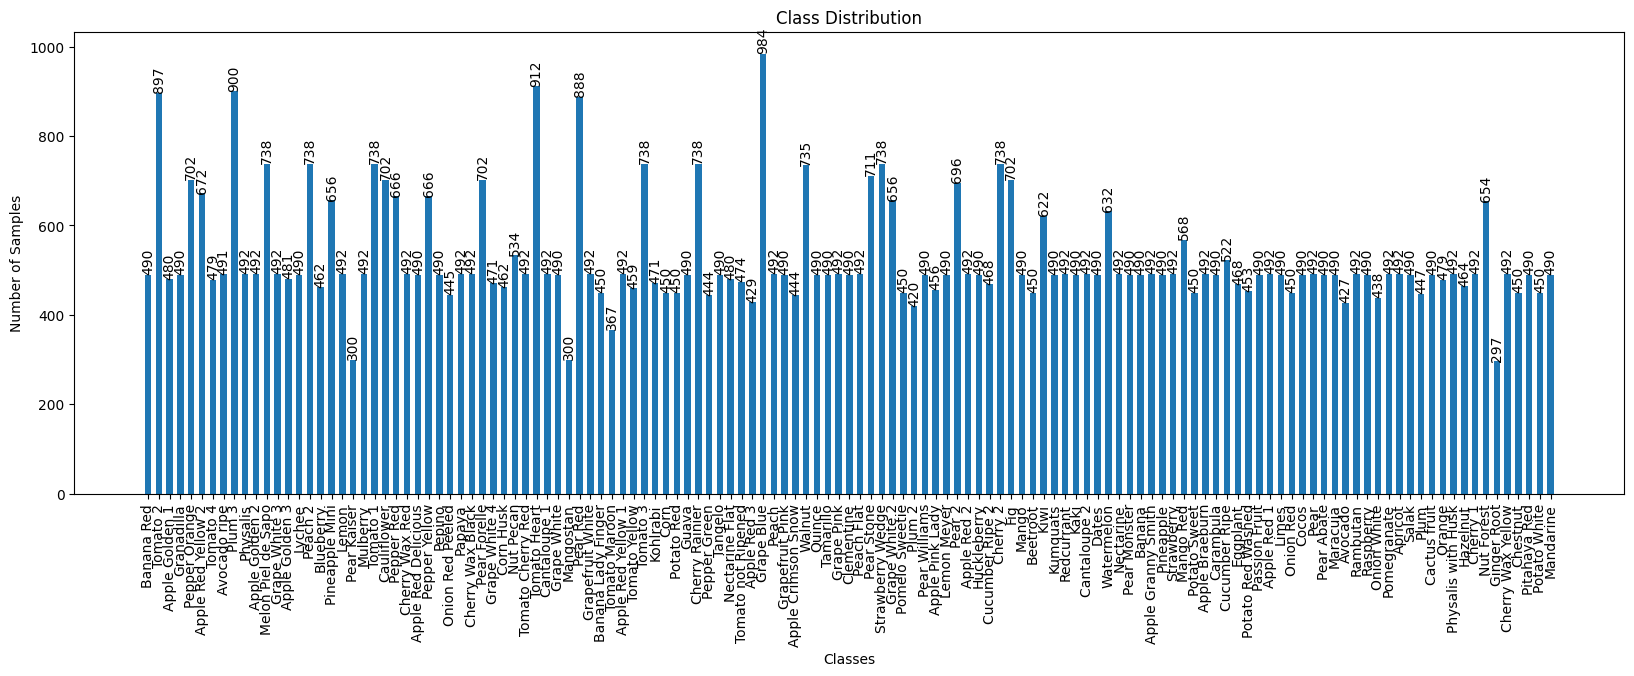

In [16]:
def generate_class_distribution_chart(folder_path):
    # Get all subdirectories (classes) in the folder
    classes = [d for d in os.listdir(folder_path) if os.path.isdir(os.path.join(folder_path, d))]

    # Count the number of samples in each class
    class_counts = {}
    for class_name in classes:
        class_dir = os.path.join(folder_path, class_name)
        file_count = len([f for f in os.listdir(class_dir) if os.path.isfile(os.path.join(class_dir, f))])
        class_counts[class_name] = file_count

    # Create a bar chart for the class distribution
    fig, ax = plt.subplots(figsize=(20, 6))  # Adjust the figure size as needed
    bars = ax.bar(class_counts.keys(), class_counts.values(), width=0.6)  # Adjust the bar width as needed
    plt.xlabel('Classes')
    plt.ylabel('Number of Samples')
    plt.title('Class Distribution')

    # Rotate x-axis labels and adjust spacing
    plt.xticks(rotation='vertical')
    
    # Add value labels on top of each bar
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, height, height, ha='center', va='bottom', rotation='vertical')

    # Show the chart
    plt.show()

generate_class_distribution_chart(train_dataset)

## Deductions

Based on the dataset description and the investigations we've done above, we can conclude the following:
> The dataset is split into Training and Test datasets + few other folders we do not need

> In the train dataset, we have 67692 images, while in train we have 22688 images, with 131 classes in each dataset.

> Image size of each image is 100x100, denoted with _100 at the end of the image names. Thus, no resizing is required.

> Each class is a vegetable or a fruit recorded on a slowly rotating motor, so simply an edible recorded from all sides.

> There are multiple types of the same vegetable. For instance, we can see that there is Tomato 1, 2, 3 and yellow.

>  

# Task 1
Choose the different classes (at least seven classes) from the 131 classes of the Fruits 360 dataset, Report the train, validation and test results.
Justify your classification results on test dataset by using AUC of ROC curve. Also provide the relevant performance metrics such sensitivity, etc.

## Class selection

We first need to pick an n amount of classes from the dataset. I wish to make it random each time.

In [17]:
# Generate random list of classes
#class_labels = train.classes
#class_list = random.sample(class_labels, k=params['class_amount'])
#print(class_list)
#class_list = ['Cactus fruit', 'Cucumber Ripe 2', 
#'Carambula', 'Tomato 4', 'Clementine', 'Cantaloupe 1', 'Potato Red', 
#'Pepino', 'Grapefruit White', 'Tomato 3']




class_list = ['Pear Abate', 'Pear Forelle', 'Pear Kaiser', 'Pear Monster', 'Pear Red', 'Pear Stone', 'Pear Williams']

In [18]:
# Path of the original dataset folder
original_dataset = train_dataset

# Path of the new dataset folder
new_train_dataset = "/home/kacper/archive/fruits-360_dataset/fruits-360/new_train"

# Remove existing new_dataset folder if it exists
if os.path.exists(new_train_dataset):
    shutil.rmtree(new_train_dataset)

# Create the new_dataset folder
os.mkdir(new_train_dataset)

# Iterate through each randomly selected folder name
for folder_name in class_list:
    # Path of the source folder
    source_folder = os.path.join(original_dataset, folder_name)
    
    # Check if the source folder exists
    if os.path.exists(source_folder):
        # Move the folder into the new_dataset folder
        shutil.move(source_folder, os.path.join(new_train_dataset, folder_name))
    else:
        print(f"Folder '{folder_name}' does not exist in the original dataset.")

print("New dataset created successfully!")

# Copy the folders from the new dataset back to the original dataset
for folder_name in os.listdir(new_train_dataset):
    source_folder = os.path.join(new_train_dataset, folder_name)
    destination_folder = os.path.join(original_dataset, folder_name)
    shutil.copytree(source_folder, destination_folder)

print("Folders copied back to the original dataset.")

New dataset created successfully!
Folders copied back to the original dataset.


In [19]:
# Path of the original dataset folder
original_dataset = test_dataset

# Path of the new dataset folder
new_test_dataset = "/home/kacper/archive/fruits-360_dataset/fruits-360/new_test"

# Remove existing new_dataset folder if it exists
if os.path.exists(new_test_dataset):
    shutil.rmtree(new_test_dataset)

# Create the new_dataset folder
os.mkdir(new_test_dataset)

# Iterate through each randomly selected folder name
for folder_name in class_list:
    # Path of the source folder
    source_folder = os.path.join(original_dataset, folder_name)
    
    # Check if the source folder exists
    if os.path.exists(source_folder):
        # Move the folder into the new_dataset folder
        shutil.move(source_folder, os.path.join(new_test_dataset, folder_name))
    else:
        print(f"Folder '{folder_name}' does not exist in the original dataset.")

print("New dataset created successfully!")

# Copy the folders from the new dataset back to the original dataset
for folder_name in os.listdir(new_test_dataset):
    source_folder = os.path.join(new_test_dataset, folder_name)
    destination_folder = os.path.join(original_dataset, folder_name)
    shutil.copytree(source_folder, destination_folder)

print("Folders copied back to the original dataset.")

New dataset created successfully!
Folders copied back to the original dataset.


In [20]:
os.listdir(new_train_dataset)

['Pear Kaiser',
 'Pear Forelle',
 'Pear Red',
 'Pear Stone',
 'Pear Williams',
 'Pear Monster',
 'Pear Abate']

In [21]:
os.listdir(new_test_dataset)

['Pear Kaiser',
 'Pear Forelle',
 'Pear Red',
 'Pear Stone',
 'Pear Williams',
 'Pear Monster',
 'Pear Abate']

### Data Loading
We should now load the data so we can train it.

In [22]:
x = datasets.ImageFolder(new_train_dataset, transform=basic_data_transforms)
y = datasets.ImageFolder(new_test_dataset, transform=basic_data_transforms)
train_loader = torch.utils.data.DataLoader(x, batch_size=params["batch_size"], num_workers=4)
test_loader = torch.utils.data.DataLoader(y, batch_size=params["batch_size"], num_workers=4)

In [23]:
import torch
import torch.nn as nn

model = nn.Sequential(
    nn.Conv2d(3, 16, kernel_size=5, stride=1, padding=3),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Flatten(),
    nn.Linear(16 * 51 * 51, 512),
    nn.ReLU(),
    nn.Linear(512, params['class_amount'])
)

In [24]:
# Create an optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=params['learning_rate'])

Epoch [1]: Train Loss: 17.7103
Epoch [2]: Train Loss: 20.3536
Epoch [3]: Train Loss: 7.5511
Epoch [4]: Train Loss: 2.1779
Epoch [5]: Train Loss: 5.4089
Epoch [6]: Train Loss: 1.8023
Epoch [7]: Train Loss: 1.9897
Epoch [8]: Train Loss: 1.4720
Epoch [9]: Train Loss: 0.5668
Epoch [10]: Train Loss: 0.6238


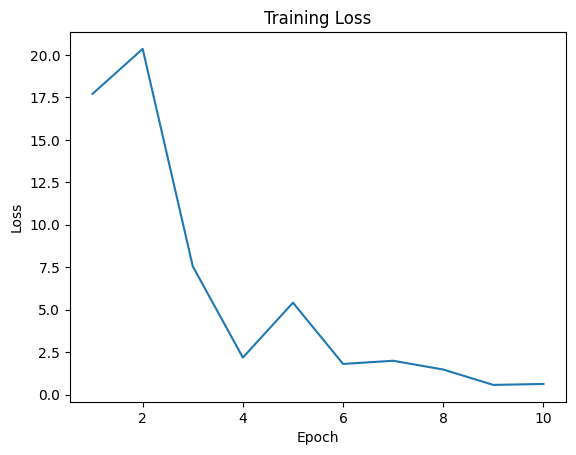

Accuracy on the test set: 81.52%


In [25]:
# Lists to store the epoch numbers and corresponding losses
epoch_nums = []
loss_values = []

model.train()
for epoch in range(params['epoch_number']):
    running_loss = 0.0

    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = torch.nn.functional.cross_entropy(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
 
    epoch_loss = running_loss / len(train_loader)
    epoch_nums.append(epoch + 1)
    loss_values.append(epoch_loss)
    print(f"Epoch [{epoch + 1}]: Train Loss: {epoch_loss:.4f}")  

# Plotting the loss graph
plt.plot(epoch_nums, loss_values)  
plt.xlabel('Epoch')  
plt.ylabel('Loss')  
plt.title('Training Loss')  
plt.show() 

# Evaluate the model on the test set
correct = 0
model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == labels).sum().item()

print(f"Accuracy on the test set: {correct / len(y):.2%}")

In [26]:
# Initialize empty lists to store true labels and predictions
true_labels = []
predicted_labels = []
correct = 0

# Accumulate true labels and predictions for all mini-batches in the test set
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        true_labels.extend(labels.numpy())
        predicted_labels.extend(predicted.numpy())
        correct += (predicted == labels).sum().item()

# Calculate precision, recall, and F1 score using the accumulated true labels and predictions
precision = precision_score(true_labels, predicted_labels, pos_label='positive', average='micro')
recall = recall_score(true_labels, predicted_labels, pos_label='positive', average='micro')
f1 = f1_score(true_labels, predicted_labels, pos_label='positive', average='micro')

print(f"Precision: {precision:.2f}, Recall: {recall:.2f}, F1 score: {f1:.2f}")

Precision: 0.82, Recall: 0.82, F1 score: 0.82


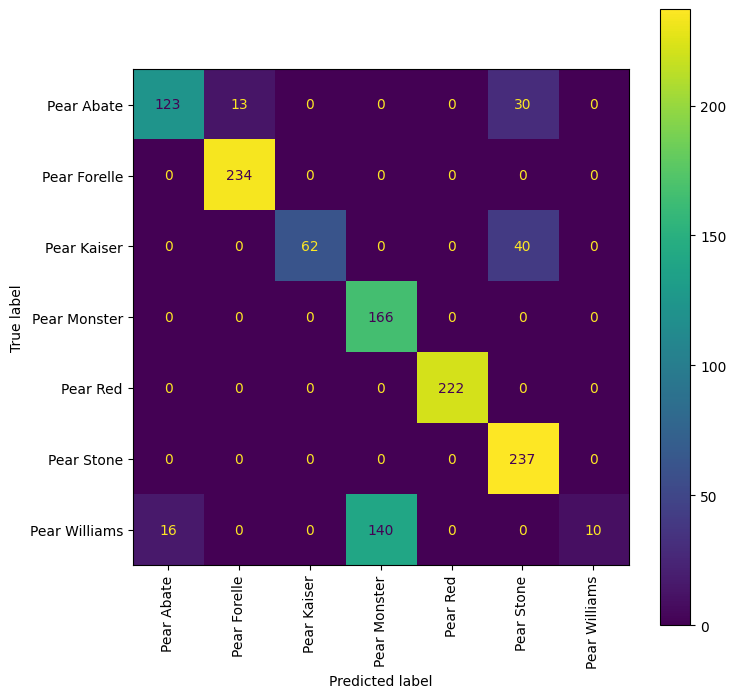

In [27]:
# Calculate the confusion matrix using the accumulated true labels and predictions
cm = confusion_matrix(true_labels, predicted_labels)

# Visualize the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_list)
fig, ax = plt.subplots(figsize=(8, 8))
disp.plot(ax=ax)

# Rotate the bottom labels
plt.xticks(rotation=90)

# Show the plot
plt.show()

### Transformed dataset

In [28]:
# Path of the original dataset folder
original_dataset = train_dataset

# Path of the new dataset folder
new_train_transformed = "/home/kacper/archive/fruits-360_dataset/fruits-360/new_train_transformed"

# Remove existing new_dataset folder if it exists
if os.path.exists(new_train_transformed):
    shutil.rmtree(new_train_transformed)

# Create the new_dataset folder
os.mkdir(new_train_transformed)

# Iterate through each randomly selected folder name
for folder_name in class_list:
    # Path of the source folder
    source_folder = os.path.join(original_dataset, folder_name)
    
    # Check if the source folder exists
    if os.path.exists(source_folder):
        # Move the folder into the new_dataset folder
        shutil.move(source_folder, os.path.join(new_train_transformed, folder_name))
    else:
        print(f"Folder '{folder_name}' does not exist in the original dataset.")

print("New dataset created successfully!")

# Copy the folders from the new dataset back to the original dataset
for folder_name in os.listdir(new_train_transformed):
    source_folder = os.path.join(new_train_transformed, folder_name)
    destination_folder = os.path.join(original_dataset, folder_name)
    shutil.copytree(source_folder, destination_folder)

print("Folders copied back to the original dataset.")

New dataset created successfully!
Folders copied back to the original dataset.


In [29]:
# Path of the original dataset folder
original_dataset = test_dataset

# Path of the new dataset folder
new_test_transformed = "/home/kacper/archive/fruits-360_dataset/fruits-360/new_test_transformed"

# Remove existing new_dataset folder if it exists
if os.path.exists(new_test_transformed):
    shutil.rmtree(new_test_transformed)

# Create the new_dataset folder
os.mkdir(new_test_transformed)

# Iterate through each randomly selected folder name
for folder_name in class_list:
    # Path of the source folder
    source_folder = os.path.join(original_dataset, folder_name)
    
    # Check if the source folder exists
    if os.path.exists(source_folder):
        # Move the folder into the new_dataset folder
        shutil.move(source_folder, os.path.join(new_test_transformed, folder_name))
    else:
        print(f"Folder '{folder_name}' does not exist in the original dataset.")

print("New dataset created successfully!")

# Copy the folders from the new dataset back to the original dataset
for folder_name in os.listdir(new_test_transformed):
    source_folder = os.path.join(new_test_transformed, folder_name)
    destination_folder = os.path.join(original_dataset, folder_name)
    shutil.copytree(source_folder, destination_folder)

print("Folders copied back to the original dataset.")

New dataset created successfully!
Folders copied back to the original dataset.


In [30]:
os.listdir(new_train_transformed)

['Pear Kaiser',
 'Pear Forelle',
 'Pear Red',
 'Pear Stone',
 'Pear Williams',
 'Pear Monster',
 'Pear Abate']

In [31]:
os.listdir(new_test_transformed)

['Pear Kaiser',
 'Pear Forelle',
 'Pear Red',
 'Pear Stone',
 'Pear Williams',
 'Pear Monster',
 'Pear Abate']

### Data Loading
We should now load the data so we can train it.

In [32]:
x = datasets.ImageFolder(new_train_transformed, transform=data_transforms)
y = datasets.ImageFolder(new_test_transformed, transform=data_transforms)
train_loader = torch.utils.data.DataLoader(x, batch_size=params["batch_size"], num_workers=4)
test_loader = torch.utils.data.DataLoader(y, batch_size=params["batch_size"], num_workers=4)

In [33]:
import torch.nn as nn

model = nn.Sequential(
    nn.Conv2d(3, 16, kernel_size=5, stride=1, padding=3),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Flatten(),
    nn.Linear(16 * 51 * 51, 512),
    nn.ReLU(),
    nn.Linear(512, params['class_amount'])
)

In [34]:
# Create an optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=params['learning_rate'])

Epoch [1]: Train Loss: 18.2210
Epoch [2]: Train Loss: 6.4113
Epoch [3]: Train Loss: 1.5015
Epoch [4]: Train Loss: 1.1073
Epoch [5]: Train Loss: 0.8769
Epoch [6]: Train Loss: 0.7114
Epoch [7]: Train Loss: 0.5483
Epoch [8]: Train Loss: 0.4707
Epoch [9]: Train Loss: 0.4877
Epoch [10]: Train Loss: 0.3673


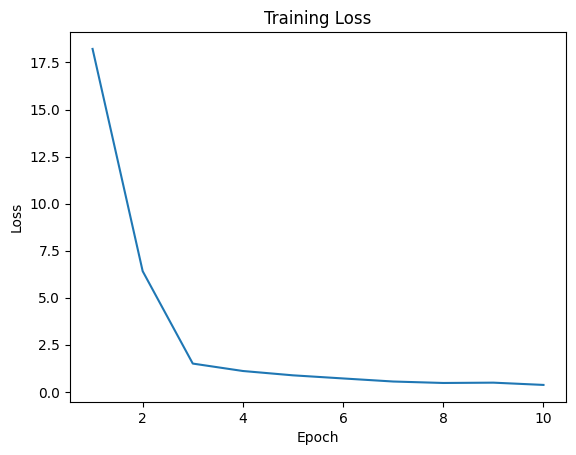

Accuracy on the test set: 83.37%


In [35]:
# Lists to store the epoch numbers and corresponding losses
epoch_nums = []
loss_values = []

model.train()
for epoch in range(params['epoch_number']):
    running_loss = 0.0

    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = torch.nn.functional.cross_entropy(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
 
    epoch_loss = running_loss / len(train_loader)
    epoch_nums.append(epoch + 1)
    loss_values.append(epoch_loss)
    print(f"Epoch [{epoch + 1}]: Train Loss: {epoch_loss:.4f}")  

# Plotting the loss graph
plt.plot(epoch_nums, loss_values)  
plt.xlabel('Epoch')  
plt.ylabel('Loss')  
plt.title('Training Loss')  
plt.show() 

# Evaluate the model on the test set
correct = 0
model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == labels).sum().item()

print(f"Accuracy on the test set: {correct / len(y):.2%}")

In [36]:
# Initialize empty lists to store true labels and predictions
true_labels = []
predicted_labels = []
correct = 0

# Accumulate true labels and predictions for all mini-batches in the test set
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        true_labels.extend(labels.numpy())
        predicted_labels.extend(predicted.numpy())
        correct += (predicted == labels).sum().item()

# Calculate precision, recall, and F1 score using the accumulated true labels and predictions
precision = precision_score(true_labels, predicted_labels, pos_label='positive', average='micro')
recall = recall_score(true_labels, predicted_labels, pos_label='positive', average='micro')
f1 = f1_score(true_labels, predicted_labels, pos_label='positive', average='micro')

print(f"Precision: {precision:.2f}, Recall: {recall:.2f}, F1 score: {f1:.2f}")

Precision: 0.85, Recall: 0.85, F1 score: 0.85


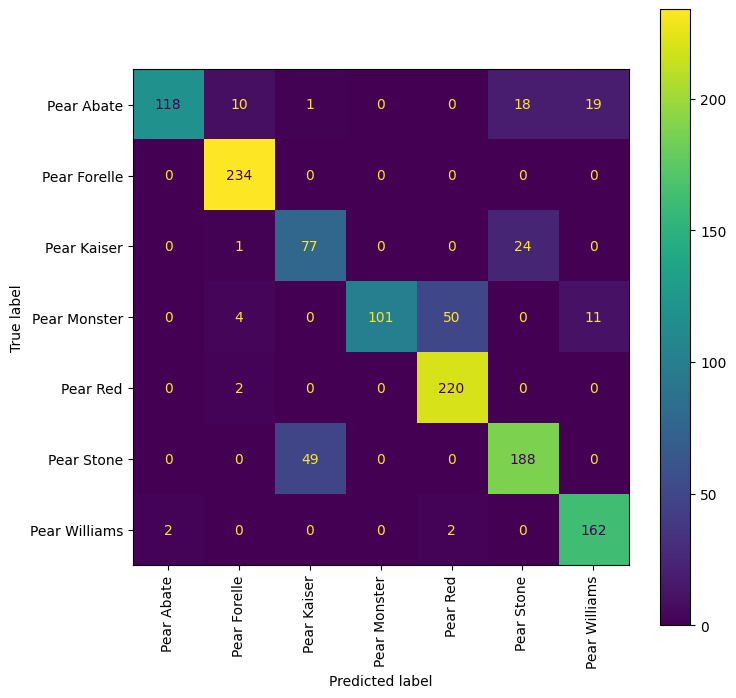

In [37]:
# Calculate the confusion matrix using the accumulated true labels and predictions
cm = confusion_matrix(true_labels, predicted_labels)

# Visualize the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_list)
fig, ax = plt.subplots(figsize=(8, 8))
disp.plot(ax=ax)

# Rotate the bottom labels
plt.xticks(rotation=90)

# Show the plot
plt.show()

# Task 2
Change the selected classes to Pear (different varieties, Abate, Forelle, Kaiser, Monster, Red, Stone, Williams) or Apples (different varieties: Crimson Snow, Golden, Golden-Red, Granny Smith, Pink Lady, Red, Red Delicious), and report the results providing relevant metrics.
Justify the difference between the results of this part and the previous.

In [38]:
pear_class_labels = ['Pear Abate', 'Pear Forelle', 'Pear Kaiser', 'Pear Monster', 
                     'Pear Red', 'Pear Stone', 'Pear Williams']
#class_list = random.choices(class_labels, k=params['class_amount'])
print(pear_class_labels)

['Pear Abate', 'Pear Forelle', 'Pear Kaiser', 'Pear Monster', 'Pear Red', 'Pear Stone', 'Pear Williams']


In [39]:
# Filter the dataset to keep only the selected classes
pear_train_samples = [(sample, label) for sample, label in train.samples if train.classes[label] in pear_class_labels]
pear_test_samples = [(sample, label) for sample, label in test.samples if train.classes[label] in pear_class_labels]
# Create the subsets of the data
pear_train_dataset_subset = torch.utils.data.Subset(train, pear_train_samples)
pear_test_dataset_subset = torch.utils.data.Subset(test, pear_test_samples)

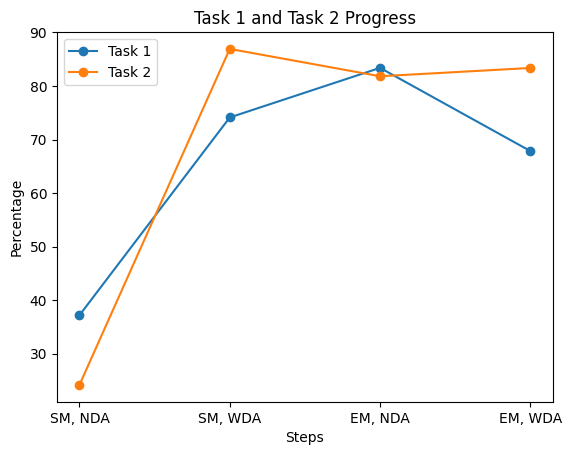

In [41]:
# Data for Task 1 and Task 2
task1 = [37.15, 74.12, 83.39, 67.84]
task2 = [24.13, 86.93, 81.82, 83.37]

# X-axis labels
x_labels = ['SM, NDA', 'SM, WDA', 'EM, NDA', 'EM, WDA']

# Plotting the line chart
plt.plot(x_labels, task1, marker='o', label='Task 1')
plt.plot(x_labels, task2, marker='o', label='Task 2')

# Adding labels and title
plt.xlabel('Steps')
plt.ylabel('Percentage')
plt.title('Task 1 and Task 2 Progress')

# Adding a legend
plt.legend()

# Displaying the line chart
plt.show()